In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from annot import combined_dic


### Reading Dataframe

In [39]:
sentences = []
labels = []
files = []

for file_name, contents in combined_dic.items():
    for sentence, label in contents.items():
        sentences.append(sentence)
        labels.append(label.lower())
        files.append(file_name)

# Creating DataFrame
df = pd.DataFrame({'Text': sentences, 'Label': labels, 'File': files})

In [40]:
df

,Text,Label,File
0,Aj subah mein 7:30 pe uthi aur uth ker apne ka...,neutral,165_Day8.txt
1,Uske baad meine apne liye nashta banaya aur ty...,neutral,165_Day8.txt
2,9 bajay office ke liye niklay sab.,neutral,165_Day8.txt
3,Aj office mein sabki pictures khichi aur group...,positive,165_Day8.txt
4,Shaam ko sab bahir khana khanay ke liye tyar hue.,neutral,165_Day8.txt
...,...,...,...
578,Phir ghar walon ke saath baith kar chai peeti ...,positive,402_Day10.txt
579,Thodi der gaming ki lekin phir bhi bore ho gaya,negative,402_Day10.txt
580,Raat ko dinner ke baad doston se call pe baat ...,positive,402_Day10.txt
581,Phir YouTube par kuch videos dekhi aur thoda r...,positive,402_Day10.txt


### Test Train Split

In [34]:
# Define split ratio
train_ratio = 0.8  # 80% training, 20% testing

total_samples = len(df) # total samples

train_size = int(train_ratio * total_samples)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = df.iloc[:train_size] 
test_data = df.iloc[train_size:]   

# Display sizes
print(f"Training Data: {len(train_data)} samples")
print(f"Testing Data: {len(test_data)} samples")


Training Data: 466 samples
Testing Data: 117 samples


### Naive Bayes Classifier

In [ ]:
class NaiveBayesTextClassifier:

    def __init__(self):
        self.positive_tokens = []
        self.negative_tokens = []
        self.neutral_tokens = []
        self.negvals = np.array([])
        self.posvals = np.array([])
        self.negcounts = np.array([])
        self.poscounts = np.array([])
        self.neutcounts = np.array([])
        # define list of stopwords to remove so that they dont affect the model
        self.stop_words = [ 
        "hai", "mai", 'me' , "tum", "kaal", "parsoun", "aj", "aaj", "kal", "aur", "ko", "ki", "ke", "ka", 
        "se", "par", "mein", "bhi", "to", "wo", "kuch", "yeh", "vo", "ho", "gaya", "gayi", "kya", 
        "jis", "jise", "jo", "ab", "abhi", "phir", "agar", "lekin", "kyun", "nahi", "sab", "zyada", 
        "bhot", "haii", "the", "tha", "thi", "hun", "rha", "rhi", "rhe", "kar", "liye", "liye", "kiya", 
        "koi", "kis", "is", "us", "un", "inka", "unka", "unke", "inki", "unki", "ky", "karna", "kerna"
]

    def preprocess_text(self , text):
        text = text.lower()  # Convert to lowercase 
        text = text.replace("," , '')
        text = text.replace("!" , '')
        text = text.replace("." , '')
        words = word_tokenize(text)
        filtered_words = [word for word in words if word not in self.stop_words]  # Remove stop words

        return filtered_words
    

    def train(self , X , Y):
        class_counts = {'Positive': 0 , 'Negative' : 0 , 'Neutral' : 0 }
        for i in range(len(X)):
            words = self.preprocess_text(X[i])
            if Y[i] == 'positive':
                for word in words:
                    self.positive_tokens.append(word)
                class_counts['Positive'] += 1
            elif Y[i] == 'negative':
                for word in words:
                    self.negative_tokens.append(word)
                class_counts['Negative'] += 1
            else:
                for word in words:
                    self.neutral_tokens.append(word)
                class_counts['Neutral'] += 1
                
        ### calculate prior probabilities of each class 
        total = 0
        for count in class_counts.values():
            total += count
        
        self.eachclassprob = {}
        for classs , count in class_counts.items():
            self.eachclassprob[classs] = count / total

        ### building vocabulary of words 
        vocab = set()
        for word in self.positive_tokens: # adding positive tokens to vocabulary
            vocab.add(word)
        for word in self.negative_tokens: # adding negative tokens to vocabulary
            vocab.add(word)
        for word in self.neutral_tokens: # adding neutral tokens to vocabulary
            vocab.add(word)
        vocab_size = len(vocab) # size of vocabulary
        
        positive_word_count = Counter(self.positive_tokens) # counts how many times each word appears in positive samples.
        self.positive_dict = {}
        for word , count in positive_word_count.items():
            self.positive_dict[word] = (count + 1 ) / ( len(self.positive_tokens) + vocab_size) # laplace smoothning
            
        negatice_word_count = Counter(self.negative_tokens) # counts how many times each word appears in negative samples.
        self.negative_dict = {}
        for word , count in negatice_word_count.items():
            self.negative_dict[word] = (count + 1 ) / ( len(self.negative_tokens) + vocab_size)
            
        neutral_word_count = Counter(self.neutral_tokens) # counts how many times each word appears in positive samples.
        self.neutral_dict = {}
        for word , count in neutral_word_count.items():
            self.neutral_dict[word] = (count + 1 ) / ( len(self.neutral_tokens) + vocab_size )

    def test(self , X):

        predictions = []
        
        all_words = set()
        
        all_words = set()
        for word in self.positive_dict:
            all_words.add(word)
        for word in self.negative_dict:
            all_words.add(word)
        for word in self.neutral_dict:
            all_words.add(word)
        vocab_size = len(all_words)
            
        for text in X:
            words = self.preprocess_text(text)
            
            log_prob_positive = np.log(self.eachclassprob['Positive'])
            log_prob_negative = np.log(self.eachclassprob['Negative'])
            log_prob_neutral = np.log(self.eachclassprob['Neutral'])
            
            for word in words:
                if word in self.positive_dict: #if word is present use its prior probability
                    log_prob_positive += np.log(self.positive_dict[word])
                else:
                    log_prob_positive += np.log(1 / (len(self.positive_tokens) + vocab_size)) # other wise use laplace smoothing
            
                if word in self.negative_dict:
                    log_prob_negative += np.log(self.negative_dict[word])
                else:
                    log_prob_negative += np.log(1 / (len(self.negative_tokens) + vocab_size))
                
                if word in self.neutral_dict:
                    log_prob_neutral += np.log(self.neutral_dict[word])
                else:
                    log_prob_neutral += np.log(1 / (len(self.neutral_tokens) + vocab_size))
                
            
            
            # store probabilies in dictionary
            probabilities = {
                'Positive': log_prob_positive,
                'Negative': log_prob_negative,
                'Neutral': log_prob_neutral
            }

            max_class = None
            max_prob = -float('inf')
            for classs , prob in probabilities.items():
                if prob > max_prob:
                    max_prob = prob
                    max_class = classs
            predictions.append(max_class)
        return predictions



### Training

In [42]:
classifier = NaiveBayesTextClassifier()

classifier.train(train_data["Text"], train_data["Label"])


### Testing

In [43]:
# Predict labels for the test set
predictions = classifier.test(test_data["Text"])

# Store actual labels
actual_labels = test_data["Label"].tolist()

# Compare predictions with actual labels
correct = sum([1 for i in range(len(predictions)) if predictions[i] == actual_labels[i]])
accuracy = correct / len(predictions) * 100

print(f"Model Accuracy: {accuracy }%")


Model Accuracy: 50.427350427350426%


### Sentiment Trends

In [ ]:
data = []
for file, entries in combined_dic.items():
    parts = file.split("_")
    
    if len(parts) > 1 and "Day" in parts[1]:  
        day_part = parts[1].replace("Day", "").split(".")[0]  # Remove ".txt" from file

        try:
            date = int(day_part)  # Convert to integer
            for text, label in entries.items():
                data.append([date, text, label.lower()])
        except ValueError:
            print(f"Skipping invalid filename: {file}")  
    else:
        print(f"Skipping unexpected filename format: {file}")  

df = pd.DataFrame(data, columns=["Day", "Text", "Sentiment"])
df = df.sort_values(by="Day")  


Skipping unexpected filename format: 225day2.txt
Skipping unexpected filename format: 380_day12.txt


In [ ]:
# Count occurrences of each sentiment per day
sentiment_counts = df.groupby("Day")["Sentiment"].value_counts().unstack().fillna(0)

# Convert counts to percentages
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100


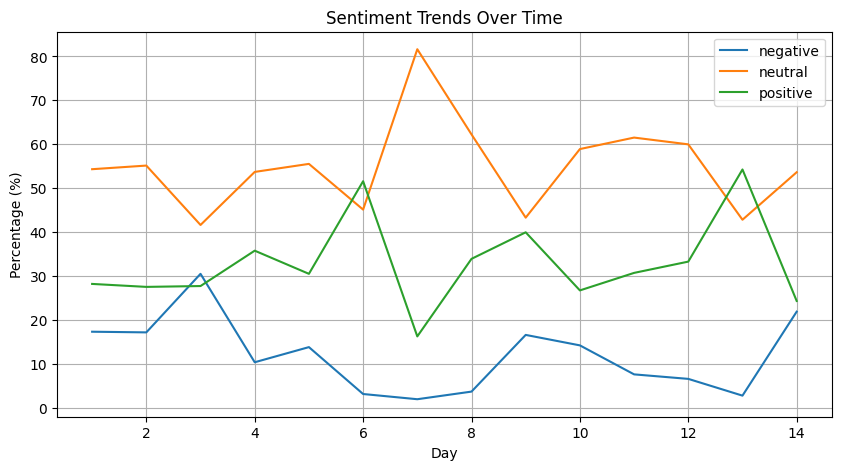

In [ ]:
plt.figure(figsize=(10, 5))
for sentiment in sentiment_percentages.columns:
    plt.plot(sentiment_percentages.index, sentiment_percentages[sentiment], label=sentiment)

plt.xlabel("Day")
plt.ylabel("Percentage (%)")
plt.title("Sentiment Trends Over Time")
plt.legend()
plt.grid()
plt.show()
